In [192]:
import numpy as np
import pandas as pd
from Levenshtein import distance
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scib
import anndata as ad

## Data Processing

In [123]:
# --- get list of file names --- #
directory = "data/IGHV1_58_repertoires"
directory_contents = os.listdir(directory)

# filtering function
def filter_condition(string):
    return "clone-pass.tsv" in string

file_names = [file for file in directory_contents if filter_condition(file)]

In [124]:
# --- parameters --- #
target_junction_length = 54 # 3 * number of amino acids

# ----- read in and process data into master pd dataframe ----- #
full_data = pd.DataFrame()

for file in file_names:
    file_data = pd.read_csv(directory + '/' + file, sep = '\t')

    # select columns
    file_data = file_data[["sequence_id", "sample_id", "subject_id", "clone_id", "v_call", "j_call", "junction_aa", "junction_length", "locus"]]

    # concatenate to full data DF
    full_data = pd.concat([full_data, file_data])

In [125]:
# ----- filter data ----- #
# - filter junction length; locus (keep heavy chains only)
filtered_data = full_data.loc[(full_data["junction_length"] == target_junction_length) & 
                              (full_data["locus"] == "IGH")
                              ]

# - filter v_call/j_call (TO IMPLEMENT IF NEEDED)

# - remove duplicates
filtered_data = filtered_data.drop_duplicates(["subject_id",  "junction_aa"])

# - select certain list of subjects, etc.
# filter_list = []

# reset index
filtered_data = filtered_data.reset_index(drop=True)

## Compute Distance + Adjacency Matrix

In [126]:
# ----- distance matrix ----- #
def hamming_distance_norm_str(str1, str2):
    assert len(str1) == len(str2)
    return sum(c1 != c2 for c1, c2 in zip(str1, str2)) / len(str1)

junction_aa_data = pd.DataFrame(filtered_data["junction_aa"])

# compute distances
pairwise_distances = pdist(junction_aa_data, lambda x,y: hamming_distance_norm_str(x[0], y[0])) 
distance_matrix = squareform(pairwise_distances)

In [127]:
# ----- adjacency matrix ----- #
threshold = 3.0/18.0

boolean_matrix = (distance_matrix <= threshold)
adjacency_matrix = boolean_matrix * 1 # boolean to 0/1. 
np.fill_diagonal(adjacency_matrix, 0) # no self-edges

# matrix of distances (iff <= threshold; edges only if positive distance)
distance_adjacency_matrix = np.multiply(distance_matrix, adjacency_matrix)

# print(np.max(distance_adjacency_matrix)) # <= threshold

## Graph Creation and Analysis

In [219]:
# --- create graph from adjacency matrix --- #
G = nx.from_numpy_array(adjacency_matrix) # 1790 nodes, 2994 edges when threshold=3.0/18.0

# --- add in attribute data --- #
for i in G.nodes:
    # add in attributes of individual, sequence
    G.nodes[i]["subject_id"] = filtered_data.iloc[i]["subject_id"]
    G.nodes[i]["junction_aa"] = filtered_data.iloc[i]["junction_aa"]
    # G.nodes[i]["clone_id"] = filtered_data.iloc[i]["clone_id"] # etc.

# G.nodes.data()

In [129]:
# --- list of remove/keep conditions for subgraph creation + analysis --- #
# - TRUE if node is isolated (deg = 0)
def is_isolate(graph, node):
    return nx.is_isolate(graph, node) # wrapper

# - TRUE if node has neighbors from at least k different subjects
def has_k_subject_neighbors(graph, node, k):
    set_of_neighbor_subjects = set() # keeps track of unique neighbors

    node_neighbors = G.adj[node] # nx atlasview object

    for neighbor, edge_attribute in node_neighbors.items():
        set_of_neighbor_subjects.add(G.nodes[neighbor]["subject_id"])

    return (len(set_of_neighbor_subjects) >= k)
    


In [130]:
# --- function to add a color column to a dataframe --- #
# inputs: dataframe, chosen sns color palette
# returns: dataframe with extra column, color_map just in case - !! NOT NEEDED; *mutates in place*
def add_color_column(dataframe, color_palette_str=None):
    n = dataframe.shape[0]
    unique_subjects_list = dataframe["subject_id"].unique() # set
    n_unique_subjects = len(unique_subjects_list) 

    # seaborn color palette; dictionary mapping
    rgb_values = sns.color_palette(palette = color_palette_str, n_colors = n_unique_subjects)
    color_map = dict(zip(unique_subjects_list, rgb_values)) # !! contains repeats if too many unique subjects

    new_dataframe = dataframe        # points to same object; changes the dataframe passed in
    # new_dataframe = dataframe.copy() # new object

    new_dataframe["color"] = new_dataframe["subject_id"].map(color_map)
    
    color_list = new_dataframe["color"] # in case needed

    return (new_dataframe, color_map) # in case needed


In [131]:
# --- testing block --- #
print(filtered_data.shape)
new_filtered_data, new_color_map = add_color_column(dataframe = filtered_data)
print(filtered_data.shape)
print(new_filtered_data.shape)

# print(filtered_data.shape)
test = new_filtered_data.drop(labels = "color", axis = 1) # creates new one.
print(new_filtered_data.shape)
print(filtered_data.shape)
print(test.shape)

print(id(filtered_data)) # check if objects are the same
print(id(new_filtered_data))
print(id(test))


(1790, 9)
(1790, 10)
(1790, 10)
(1790, 10)
(1790, 10)
(1790, 9)
7251125888
7251125888
4722918640


In [159]:
# --- function to create subgraph and subdataframe for analysis --- #
# inputs: graph, corresponding data, remove or keep condition functions f(graph, node)
# returns: new graph and dataframe (with colors per subject)
# !care: copy() subgraph attributes are shared with original graph (if mutable); can be reassigned though
def create_subgraph(graph, dataframe, remove_condition = None, keep_condition = None, node_subset = None):
    # require that dataframe matches graph, and graph node labels are dataframe indexes
    # could want a 'node_label' column in dataframe matching node labels in the future.
    assert len(G.nodes) == dataframe.shape[0]

    # --- create subgraph and subdataframe based on filter condition --- #
    # use remove condition if passed in
    if callable(remove_condition):
        # compute nodes to remove
        nodes_to_remove = []
        for node in graph.nodes:
            if remove_condition(graph, node):
                nodes_to_remove.append(node)

        # create subgraph
        new_subgraph = graph.copy()
        new_subgraph.remove_nodes_from(nodes_to_remove)

        # create subdataframe
        new_subdataframe = dataframe.drop(nodes_to_remove, axis=0) # assumes node labels are the same as df index

    # use keep condition if passed in
    elif callable(keep_condition):
        nodes_to_keep = []
        for node in graph.nodes:
            if keep_condition(graph, node):
                nodes_to_keep.append(node)

        # create subgraph
        new_subgraph = graph.subgraph(nodes_to_keep).copy()

        # create subdataframe
        new_subdataframe = dataframe.loc[nodes_to_keep] # assumes node labels are the same as df index

    # use subset of nodes if given
    elif node_subset != None:
        # node_subset = list(node_subset)
        
        new_subgraph = graph.subgraph(node_subset).copy()

        new_subdataframe = dataframe.loc[node_subset]

    # default - do nothing
    else:
        new_subgraph = graph.copy()
        new_subdataframe = dataframe 

    # --- create color column in new_subdataframe
    new_subdataframe, subgraph_color_map = add_color_column(dataframe = new_subdataframe) # color_map 

    # return
    return (new_subgraph, new_subdataframe)
        
# --- testing --- #
new_subgraph, new_subdataframe = create_subgraph(graph = G, dataframe = filtered_data, remove_condition = is_isolate)
print(len(new_subgraph))
print(new_subdataframe.head()) # should have same length; 1 extra column with colors
colors_palette = new_subdataframe["color"]
# nx.draw_networkx(new_subgraph, node_size=10, width=2, with_labels=False, node_color = colors_palette)



562
                 sequence_id sample_id subject_id  clone_id       v_call  \
2   5f48586f869e21b4c2be5c86  S22-rep3        S22     14070  IGHV1-58*02   
3   5f48586f869e21b4c2be5c8b  S22-rep3        S22     14070  IGHV1-58*02   
6   5f48586f869e21b4c2be30db  S22-rep3        S22     14137  IGHV1-58*02   
10  609d892c579d39f681d21196   Pt-35-1      Pt-35      4356  IGHV1-58*02   
11  609d892c579d39f681d2cd0c   Pt-35-1      Pt-35      4356  IGHV1-58*02   

               j_call         junction_aa  junction_length locus  \
2            IGHJ4*02  CAAADYGDSRGKSSFDYW               54   IGH   
3   IGHJ4*01,IGHJ4*02  CAAADYGDSWGKSSFDYW               54   IGH   
6            IGHJ6*02  CAAEVRGSYYYYYGMDVW               54   IGH   
10           IGHJ4*02  CAAGYDSHPMAASQFDYW               54   IGH   
11           IGHJ4*02  CAAGYDSHPMAASQFDFW               54   IGH   

                                                color  
2   (0.12156862745098039, 0.4666666666666667, 0.70...  
3   (0.12156862745

### Connected components analysis

In [133]:
# ----- functions for processing connected components ----- #

# --- helper to count the number of unique subjects given list of nodes --- #
# inputs: graph, iterable nodes
# returns: number of unique subjects
def count_unique_subjects(graph, nodes):
    unique_subjects_set = set()

    for node in nodes:
        unique_subjects_set.add(graph.nodes[node]["subject_id"]) # can even pass in desired column name (str)

    return len(unique_subjects_set) 

# --- list of remove/keep conditions for connected components --- #
# - TRUE if connected component has at least n_nodes nodes
def has_atleast_node(graph, cc, n_nodes=1):
    return len(cc) >= n_nodes

# - TRUE if connected component has at least n_subject unique subjects
def has_atleast_subject(graph, cc, n_subjects=1):
    return count_unique_subjects(graph, cc) >= n_subjects

# - TRUE if connected component has at least n_nodes nodes and n_subjects unique subjects
def has_atleast_node_subject(graph, cc, n_nodes=1, n_subjects=1):
    return has_atleast_node(graph, cc, n_nodes=n_nodes) and has_atleast_subject(graph, cc, n_subjects=n_subjects) # wrapper




In [165]:
# ----- functions for processing nodes in connected components ----- #

# --- manual statistics of nodes in cc --- #
# counts number of unique subjects among a node's neighbors
def count_unique_subjects_among_neighbors(subgraph, node):
    unique_neighbors_set = set()

    for neighbor in subgraph.neighbors(node):
        unique_neighbors_set.add(subgraph.nodes[neighbor]["subject_id"])

    return len(unique_neighbors_set)

# counts number of neighbors that come from a different subject from itself
def count_different_subject_neighbors(subgraph, node):
    count = 0

    node_subject_id = subgraph.nodes[node]["subject_id"]

    for neighbor in subgraph.neighbors(node):
        if subgraph.nodes[neighbor]["subject_id"] != node_subject_id:
            count += 1

    return count

#### Looping through connected components - Pseudocode

G_cc_data stores 1 row per connected component

cc_id_df_dict is a dict mapping connected components to dataframes containing data about its nodes

For each connected component:
- do we want to exclude any connected components?
- compute information (id, node count, etc.) about connected components
    - create row; concat with G_cc_data
- create a dataframe to store node-level information
- For each node in the connected component:
    - compute statistics/metrics; create a new column per statistic
    - add this dataframe into dictionary cc_id_df_dict


In [166]:
# ----- ANALYSIS: loop through connected components ----- #
#                                                         #
#        compute master dataframe + cc dataframes         #
#                                                         #
# ------------------------------------------------------- #

# --- pre-creating table for connected components of G --- #
# 1 row per connected component
# cc_id should contain info about it, like junction_length, v_call, j_call (for when we partition)
# assume v_call, j_call, junction_length constant per connected component
G_cc_data = pd.DataFrame()
G_id_base = "v_call_j_call_junction_length" # can change later
cc_counter = 0 # for cc indexing

# --- link cc_id and set of nodes with dict --- #
cc_id_nodes_dict = {} # links cc_id with nodes
cc_id_df_dict = {} # links cc_id with cc dataframe (contains node statistics)

# ----------------------- #
#       MASTER LOOP       #
# ----------------------- #
# per cc: add info to main dataframe G_cc_data
for cc in nx.connected_components(G): 
    # --- [optional] filter conditions for connected components --- #
    if not has_atleast_node_subject(G, cc, n_nodes=3, n_subjects=2):
        continue

    # --- subgraph + basic information for use --- #
    cc_subgraph = G.subgraph(cc).copy()
    cc_node_count = len(cc_subgraph.nodes) # number of nodes
    cc_edge_count = len(cc_subgraph.edges) # number of edges

    # ----- STEP 1: create row with info for cc; concat to master df ----- #
    column_names = ["cc_id", "n_subjects", "n_nodes", "v_call", "nodes", "edge_connectivity"] # better way to do this?

    # information + statistics
    cc_id = G_id_base + "_" + str(cc_counter) # important
    cc_n_subjects = count_unique_subjects(G, cc)
    cc_n_nodes = len(cc)
    cc_v_call = "IGHV1-58"
    cc_edge_connectivity = cc_edge_count / (cc_node_count * (cc_node_count - 1) / 2) # edge count / total possible count

    data_list = [[cc_id, cc_n_subjects, cc_n_nodes, cc_v_call, cc, cc_edge_connectivity]]

    cc_df = pd.DataFrame(data = data_list, columns = column_names)

    # ALT METHOD - use a dictionary instead to create row?
    # ? - use cc_id as the index, instead of 0, 1, ...

    G_cc_data = pd.concat([G_cc_data, cc_df])

    # --- link id with nodes --- #
    cc_id_nodes_dict[cc_id] = cc 

    # --- finish cc-level computations --- #
    cc_counter += 1



    # ----- STEP 2: compute node statistics per cc ----- #
    cc_data = pd.DataFrame(data=list(cc), columns=["node"]) 
    # print(cc_data)
    # node_stat_names = ["deg", "n_unique_neighbors", ""] # not needed?
    
    # --- compute built in centrality measures --- #
    cc_degree_frac_dict = nx.degree_centrality(cc_subgraph) # fraction of possible nodes it's connected to (n-1)

    # print(cc)

    cc_data["degree_frac"] = cc_data["node"].map(cc_degree_frac_dict)
    cc_data["degree"] = cc_data["degree_frac"] * (len(cc_subgraph.nodes) - 1)

    cc_betweenness_centrality_dict = nx.betweenness_centrality(cc_subgraph)
    cc_data["betweenness_centrality"] = cc_data["node"].map(cc_betweenness_centrality_dict)

    # cc_katz_centrality_dict = nx.katz_centrality(cc_subgraph) # convergence issue with second cc
    # cc_data["katz_centrality"] = cc_data["node"].map(cc_katz_centrality_dict)

    # --- compute manual centrality measures --- #
    cc_data["n_unique_subjects_among_neighbors"] = cc_data.apply(lambda row: count_unique_subjects_among_neighbors(cc_subgraph, row['node']), axis=1)

    cc_data["n_different_subject_neighbors"] = cc_data.apply(lambda row: count_different_subject_neighbors(cc_subgraph, row['node']), axis=1)

    # - TO IMPLEMENT: compute LISI metric - #
    # scib library doesn't do it per node? it returns average 

    # --- TO IMPLEMENT: add node statistics to G_cc_data (to sort cc's by something)

    # --- add final results to dictionary --- #
    cc_id_df_dict[cc_id] = cc_data


    # print(cc_data)

    # break

# print(cc_id_df_dict)

G_cc_data = G_cc_data.reset_index(drop=True)

print(G_cc_data.head())
# print(type(G_cc_data.loc[3]["nodes"])) # still a set, nice!
# print(cc_id_nodes_dict)




                             cc_id  n_subjects  n_nodes    v_call  \
0  v_call_j_call_junction_length_0          15       36  IGHV1-58   
1  v_call_j_call_junction_length_1           2       33  IGHV1-58   
2  v_call_j_call_junction_length_2           5        5  IGHV1-58   
3  v_call_j_call_junction_length_3          18      182  IGHV1-58   
4  v_call_j_call_junction_length_4           2        4  IGHV1-58   

                                               nodes  edge_connectivity  
0  {1536, 1537, 6, 1414, 270, 1038, 271, 1688, 14...           0.068254  
1  {31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...           0.890152  
2                        {1410, 1160, 655, 88, 1470}           0.400000  
3  {1025, 1538, 1539, 1039, 1050, 1051, 1052, 105...           0.123368  
4                            {1548, 1549, 222, 1550}           1.000000  


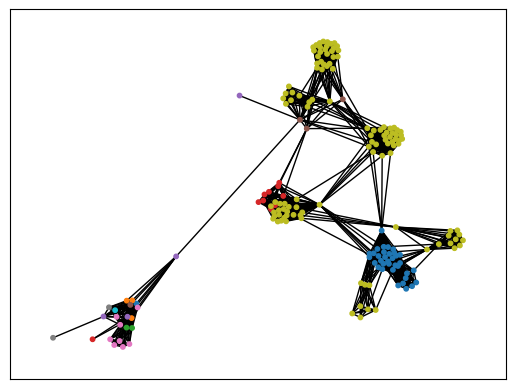

In [167]:
# ----- examine data from above ----- #
# - sort by n_nodes; look at biggest ones first
G_cc_data_sort_n_nodes = G_cc_data.sort_values(by=['n_nodes'], ascending=False).reset_index()

# G_cc_data_sort_n_nodes.head()

# --- examine largest cc --- #
largest_cc_nodes = G_cc_data_sort_n_nodes.loc[0, 'nodes'] # loc is label; iloc is just regular 'k'th row.
largest_cc_id = G_cc_data_sort_n_nodes.loc[0, 'cc_id']

# - Method 1: create_subgraph
largest_cc_subgraph, largest_cc_subdataframe = create_subgraph(graph = G, dataframe = filtered_data, node_subset = list(largest_cc_nodes))
# print(largest_cc_subdataframe.shape)
colors_list = largest_cc_subdataframe["color"] # extract list of colors for nodes
nx.draw_networkx(largest_cc_subgraph, node_size=10, width=1, with_labels=False, node_color = colors_list)



In [183]:
# ----- extract important sequences from this cc ----- #
largest_cc_node_data = cc_id_df_dict[largest_cc_id]

print(largest_cc_node_data.columns)

# ---- dict of {node : sequence} for faster access --- #
node_sequence_dict = nx.get_node_attributes(largest_cc_subgraph, "junction_aa")

# --- sort by column --- #
sort_column = "n_different_subject_neighbors"

largest_cc_node_data_sorted = largest_cc_node_data.sort_values(by=[sort_column], ascending=False).reset_index(drop=True) # reset to use loc
# print(largest_cc_node_data_sorted.head())


# --- print sequences --- #
# Method 1: print fixed number of sequences
print_n = 5

candidate_sequences = []
for row in range(print_n):
    candidate_node = largest_cc_node_data_sorted.loc[row, "node"]
    candidate_sequences.append(node_sequence_dict[candidate_node])
    
print(f"{print_n} sequences with highest " + sort_column + ":")
print(candidate_sequences)

# Method 2: based on condition/threshold
stat_threshold = 10
want_greater = True

candidate_sequences = []
for row in range(largest_cc_node_data_sorted.shape[0]):

    candidate_node = largest_cc_node_data_sorted.loc[row, "node"]
    candidate_node_stat = largest_cc_node_data_sorted.loc[row, sort_column]

    if want_greater:
        if candidate_node_stat >= stat_threshold:
            candidate_sequences.append(node_sequence_dict[candidate_node])
        else:
            # since it's sorted, we can stop here.
            break
    else:
        if candidate_node_stat <= stat_threshold:
            candidate_sequences.append(node_sequence_dict[candidate_node])
        else:
            break

if want_greater:
    print(f"Sequences with " + sort_column + f" >= {stat_threshold}:")
else:
    print(f"Sequences with " + sort_column + f" <= {stat_threshold}:")
    
print(candidate_sequences)


Index(['node', 'degree_frac', 'degree', 'betweenness_centrality',
       'n_unique_subjects_among_neighbors', 'n_different_subject_neighbors'],
      dtype='object')
5 sequences with highest n_different_subject_neighbors:
['CAAPSCSRTTCYDGFNLW', 'CAAPPCSRTTCYDGFNLW', 'CAAPSCSRTTCYDGFILW', 'CAAPSCSGGTCFDAFDIW', 'CAAPYCSSTSCYDAFDIW']
Sequences with n_different_subject_neighbors >= 10:
['CAAPSCSRTTCYDGFNLW', 'CAAPPCSRTTCYDGFNLW', 'CAAPSCSRTTCYDGFILW', 'CAAPSCSGGTCFDAFDIW', 'CAAPYCSSTSCYDAFDIW', 'CAAPYCSSTSCYDAFDIW', 'CAAVYCSSTSCSDAFDIW', 'CAAPNCSRTTCYDGFDLW', 'CAAVYCSSTSCFDAFDIW', 'CAAPYCSSTSCSDAFDIW', 'CAAPYCSSTSCDDAFDIW', 'CAAPYCSSTSCHDAFDIW', 'CAAPYCSSTSCHDAFDIW', 'CAAPYCSSTSCSDAFDIW', 'CAAVTCSSTSCYDAFDIW', 'CAAPSCSGGTCFDGFDLW', 'CAAPNCSSTSCYSAFDIW', 'CASPDCSSTSCYDAFDIW', 'CAAPSCSGGTCFDGFNLW', 'CAAPHCSTTSCYDAFDIW', 'CAAPYCSRTTCYDGFDLW']


### KNN and LISI Metric Experimentation

In [194]:
# ----- compute KNN matrix ----- #
k = 10 # number of nearest neighbors to grab

largest_cc_subgraph_distances = dict(nx.all_pairs_shortest_path_length(largest_cc_subgraph))

largest_cc_subgraph_knn_matrix = pd.DataFrame()

for node in largest_cc_subgraph.nodes:
    distances_dict = largest_cc_subgraph_distances[node]
    sorted_distances_tuple_list = sorted(distances_dict.items(), key=lambda x:x[1]) # sort by distances; includes itself

    closest_k_neighbors = [neighbor for (neighbor, distance) in sorted_distances_tuple_list[1:(k+1)]] # don't include item 0 (itself)

    row_df = pd.DataFrame([closest_k_neighbors]) # to be concatenated
    row_df.columns = [f"neighbor_{i:d}" for i in range(k)]
    row_df.index = [node]

    largest_cc_subgraph_knn_matrix = pd.concat([largest_cc_subgraph_knn_matrix, row_df])


print(largest_cc_subgraph_knn_matrix)


      neighbor_0  neighbor_1  neighbor_2  neighbor_3  neighbor_4  neighbor_5  \
1025         171         472         475         476         477         478   
1538         275         308         430         431         765         782   
1539        1538         275         282         308         430         431   
1039        1538        1539         275         430         431         765   
1050         158         159         171         175         178         610   
...          ...         ...         ...         ...         ...         ...   
493         1025        1595        1322         472         475         476   
496         1025        1595         175        1310        1317        1319   
495         1025        1600        1603         472         475         476   
497         1025        1600         472         475         476         478   
498         1025        1595         472         475         476         478   

      neighbor_6  neighbor_7  neighbor_

In [252]:
# ----- UNFINISHED: create adata object ----- #
# adata.X - main data matrix
# adata.obs - indexes (ie. row names) of X
# adata.vars - variables (ie. column names) of X
# adata.uns - unstructured annotations
#     adata.uns["neighbors"] = k nearest neighbors
# adata.obsp - can handle more data?
#     adata.obsp["connectivities"] = adjacency matrix?

# index --> obs_names, colnames --> var_names
# !obs_names/index is converted to string
test = ad.AnnData(largest_cc_subgraph_knn_matrix) 

node_subject_id_dict = nx.get_node_attributes(largest_cc_subgraph, "subject_id")

index_list = [eval(i) for i in list(test.obs.index)] # list of nodes in the index (eval(str) --> int)
# print(index_list)

# code uses np.unique which sorts things; can't compare int and string.
test.obs["subject_id"] = list(map(node_subject_id_dict.get, index_list))
test.obs["subject_id"] = test.obs.subject_id.astype("string").astype('category') # no numerical categories; all strings
# print(test.obs["subject_id"])

test.uns["neighbors"] = largest_cc_subgraph_knn_matrix

temp = nx.adjacency_matrix(largest_cc_subgraph) # but nodes are in different orders? 
print(type(temp)) # csr array

# scib.me.clisi_graph(test, label_key="subject_id", type_="knn")



<class 'scipy.sparse._csr.csr_array'>


/opt/anaconda3/envs/sds491/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
